In [1]:
!pip install mediapipe


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 52.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 20.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.6 which is incompatible.
google-cloud-bigtable 2.27.0 requires google-api-core[grpc]<3.0.0dev,>=2.16.0, but you have google-api-core 1.34.1 which is incompatible.
pandas-gbq 0.25.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
tensorflow-decision-forests 1.10.0 requires tens

In [2]:
!pip install mediapipe scikit-learn matplotlib


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from tensorflow.keras import metrics, optimizers, Sequential, activations, callbacks
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
import keras.backend as K
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

In [4]:
train_dir = '/kaggle/input/synthetic-asl-alphabet/Train_Alphabet'
test_dir = '/kaggle/input/synthetic-asl-alphabet/Test_Alphabet'

In [5]:
def load_df(dir_path):
    df = {
        'filename': [],
        'label': []
    }
    classes = os.listdir(dir_path)
    for c in classes:
        path = dir_path + '/' + c

        img_paths = os.listdir(path)

        for img_path in img_paths:
            df['filename'].append(c + '/' + img_path)
            df['label'].append(c)
        
    df = pd.DataFrame(df)
    return df

train_df = load_df(train_dir)
test_df = load_df(test_dir)

In [6]:
train_df.sample(15)

,filename,label
11840,Blank/d2c18f39-50b3-4d35-892d-caf53d257a63.rgb...,Blank
23952,J/bf7c56fe-ed40-4088-a97b-05a4780ec985.rgb_000...,J
13383,S/f5358398-bbe5-43a5-a0a4-a9729e63f092.rgb_000...,S
17107,V/849ee0ee-568e-4c42-90e9-7f2a1fe62551.rgb_000...,V
23281,D/cc233d79-5607-42a1-87c6-5313937a5e70.rgb_000...,D
11575,Y/2721dff2-2e2a-463c-b503-432526a35e5b.rgb_000...,Y
3095,I/6b81e090-b7f5-40c3-ade1-838574b66912.rgb_000...,I
8228,X/4caecef1-f81d-4e9a-a0d7-6e1f2baeccd4.rgb_000...,X
23369,D/80feb61a-cb09-46c5-a0ce-c337a3385a77.rgb_000...,D
1222,R/c151da0e-85ce-41d4-9bb0-46066c6299cb.rgb_000...,R


In [7]:
train_df['label'].value_counts()

label
N        900
R        900
B        900
I        900
F        900
H        900
E        900
U        900
M        900
X        900
K        900
Q        900
Y        900
Blank    900
S        900
G        900
A        900
O        900
T        900
V        900
Z        900
C        900
P        900
L        900
W        900
D        900
J        900
Name: count, dtype: int64

In [8]:
def show_img(path, row):
    filename = list(row['filename'])[0]
    label = list(row['label'])[0]
    image = cv2.imread(path + '/' + filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')
    plt.show()

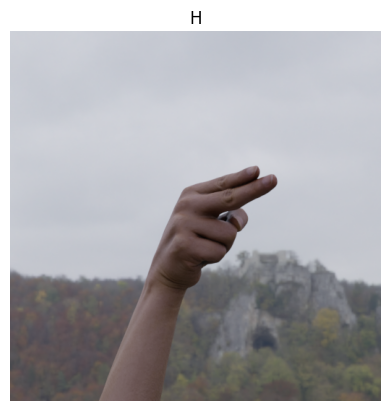

In [9]:
show_img(train_dir, train_df.sample(2))

In [10]:
X = train_df['filename']
y = train_df['label']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, random_state=1, test_size=0.2)
print(X_train.shape)
print(X_valid.shape)

(19440,)
(4860,)


In [11]:
train = pd.concat([X_train, y_train], axis=1)
valid = pd.concat([X_valid, y_valid], axis=1)
test = test_df

In [12]:
IMAGE_SIZE = (224, 224)

datagen = ImageDataGenerator(
    rescale=1./255,
#     rotation_range=40,
    zoom_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
#     brightness_range=[0.5, 1.0],
)

train_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory = train_dir,
    x_col='filename',
    y_col='label',
    batch_size=32,
    # color_mode="rgb",
    seed=42,
    shuffle=True,
    class_mode='sparse',
    target_size=IMAGE_SIZE
)

valid_generator=datagen.flow_from_dataframe(
    dataframe=valid,
    directory=train_dir,
    x_col="filename",
    y_col="label",
    batch_size=32,
    # color_mode="rgb",
    seed=42,
    shuffle=True,
    class_mode="sparse",
    target_size=IMAGE_SIZE
)

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=test_dir,
    x_col="filename",
    y_col=None,
    batch_size=1,
    # color_mode="rgb",
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=IMAGE_SIZE
)

Found 19440 validated image filenames belonging to 27 classes.
Found 4860 validated image filenames belonging to 27 classes.
Found 2700 validated image filenames.


In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Update the filename to use `.keras` extension
cb = [ModelCheckpoint('model_resnet.keras', save_best_only=True, monitor='val_loss')]


In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
n_class = 27

base_model = tf.keras.applications.ResNet50V2(include_top=False)
base_model.trainable = False

inputs = Input(shape=IMAGE_SIZE + (3,), name='input_layer')
out = base_model(inputs, training=False)
out = GlobalAveragePooling2D()(out)
out = Dense(128, activation='relu')(out)
# out = Dropout(0.2)(out)
out = Dense(n_class, activation='softmax', name='output_layer')(out)
model_resnet = keras.Model(inputs, out)

model_resnet.compile(loss='sparse_categorical_crossentropy',
                     optimizer=optimizers.Adamax(learning_rate=1e-4),
                     metrics=['accuracy'])

model_resnet.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 27)                  │           3,483 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,830,555 (90.91 MB)

 Trainable params: 265,755 (1.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [15]:
history_resnet = model_resnet.fit(train_generator, epochs=20,
                                  validation_data=valid_generator,
                                  batch_size=120,
                                  callbacks=cb)

Epoch 1/20
608/608 ━━━━━━━━━━━━━━━━━━━━ 696s 1s/step - accuracy: 0.1343 - loss: 3.1459 - val_accuracy: 0.4473 - val_loss: 2.1028
Epoch 2/20
608/608 ━━━━━━━━━━━━━━━━━━━━ 500s 815ms/step - accuracy: 0.5007 - loss: 1.9022 - val_accuracy: 0.6261 - val_loss: 1.4327
Epoch 3/20
608/608 ━━━━━━━━━━━━━━━━━━━━ 500s 815ms/step - accuracy: 0.6516 - loss: 1.3246 - val_accuracy: 0.7041 - val_loss: 1.1172
Epoch 4/20
608/608 ━━━━━━━━━━━━━━━━━━━━ 505s 824ms/step - accuracy: 0.7231 - loss: 1.0572 - val_accuracy: 0.7516 - val_loss: 0.9477
Epoch 5/20
608/608 ━━━━━━━━━━━━━━━━━━━━ 502s 817ms/step - accuracy: 0.7588 - loss: 0.8935 - val_accuracy: 0.7714 - val_loss: 0.8389
Epoch 6/20
608/608 ━━━━━━━━━━━━━━━━━━━━ 506s 825ms/step - accuracy: 0.7936 - loss: 0.7807 - val_accuracy: 0.7977 - val_loss: 0.7617
Epoch 7/20
608/608 ━━━━━━━━━━━━━━━━━━━━ 506s 825ms/step - accuracy: 0.8131 - loss: 0.7010 - val_accuracy: 0.8006 - val_loss: 0.7101
Epoch 8/20
608/608 ━━━━━━━━━━━━━━━━━━━━ 507s 827ms/step - accuracy: 0.8296 - lo

In [16]:
history_resnet_temp = history_resnet

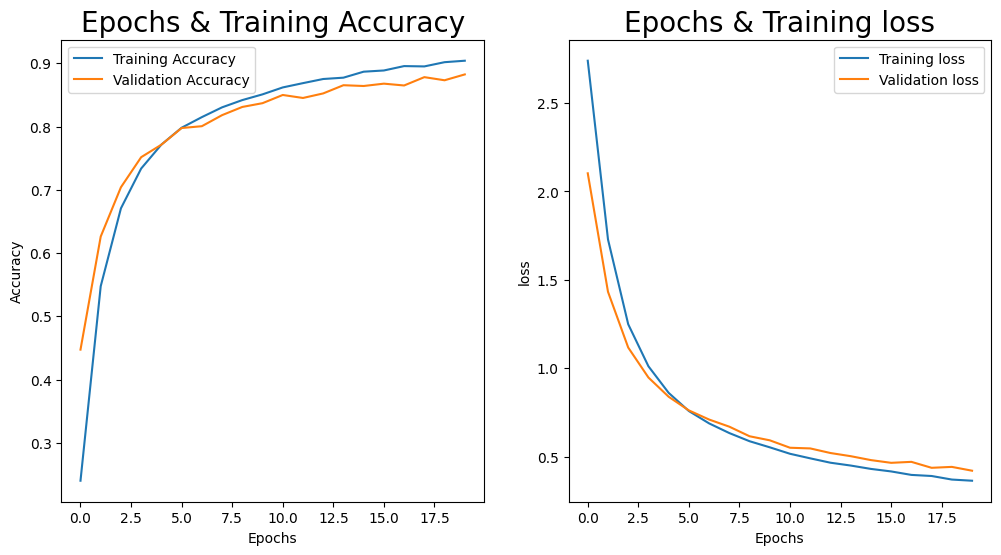

In [17]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))

ax[0].plot(history_resnet_temp.history['accuracy'], '-', label = 'Training Accuracy')
ax[0].plot(history_resnet_temp.history['val_accuracy'], '-', label = 'Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Epochs & Training Accuracy', fontsize=20)
ax[0].legend(loc='best')

ax[1].plot(history_resnet_temp.history['loss'], '-', label = 'Training loss')
ax[1].plot(history_resnet_temp.history['val_loss'], '-', label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & Training loss', fontsize=20)
ax[1].legend(loc='best')

plt.show()

In [18]:
test_generator.reset()
pred_resnet = model_resnet.predict(test_generator, verbose=1)

2700/2700 ━━━━━━━━━━━━━━━━━━━━ 55s 19ms/step


In [19]:
pred_resnet = np.argmax(pred_resnet,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_resnet = [labels[k] for k in pred_resnet]

In [20]:
accuracy_score(test['label'], pred_resnet)

0.8948148148148148

In [21]:
print(classification_report(test['label'], pred_resnet))

              precision    recall  f1-score   support

           A       0.94      0.94      0.94       100
           B       0.94      0.91      0.92       100
       Blank       0.99      0.99      0.99       100
           C       0.97      0.93      0.95       100
           D       0.90      0.87      0.88       100
           E       0.85      0.84      0.84       100
           F       0.91      0.91      0.91       100
           G       0.90      0.95      0.93       100
           H       0.94      0.97      0.96       100
           I       0.88      0.89      0.89       100
           J       0.91      0.93      0.92       100
           K       0.86      0.90      0.88       100
           L       0.97      0.94      0.95       100
           M       0.73      0.68      0.70       100
           N       0.75      0.86      0.80       100
           O       0.91      0.92      0.92       100
           P       0.93      1.00      0.96       100
           Q       0.97    

In [22]:
model_resnet.save('resnet50v2_20_ep.hdf5')

In [23]:
history_resnet = model_resnet.fit(train_generator,
                                  initial_epoch=20,
                                  epochs=30,
                                  validation_data=valid_generator,
                                  batch_size=120,
                                  callbacks=cb)

Epoch 21/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 508s 828ms/step - accuracy: 0.9047 - loss: 0.3526 - val_accuracy: 0.8782 - val_loss: 0.4345
Epoch 22/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 502s 819ms/step - accuracy: 0.9071 - loss: 0.3451 - val_accuracy: 0.8792 - val_loss: 0.4172
Epoch 23/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 498s 812ms/step - accuracy: 0.9066 - loss: 0.3400 - val_accuracy: 0.8796 - val_loss: 0.4156
Epoch 24/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 495s 806ms/step - accuracy: 0.9111 - loss: 0.3262 - val_accuracy: 0.8881 - val_loss: 0.3998
Epoch 25/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 494s 805ms/step - accuracy: 0.9172 - loss: 0.3146 - val_accuracy: 0.8852 - val_loss: 0.3956
Epoch 26/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 498s 812ms/step - accuracy: 0.9141 - loss: 0.3193 - val_accuracy: 0.8872 - val_loss: 0.3907
Epoch 27/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 499s 814ms/step - accuracy: 0.9170 - loss: 0.3076 - val_accuracy: 0.8870 - val_loss: 0.3904
Epoch 28/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 498s 812ms/step - accuracy: 

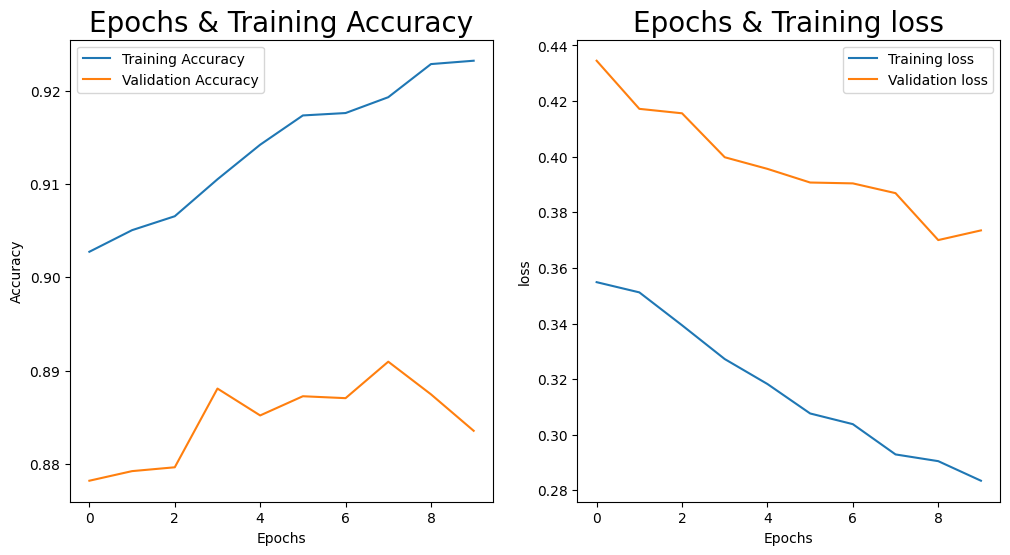

In [25]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))

ax[0].plot(history_resnet.history['accuracy'], '-', label = 'Training Accuracy')
ax[0].plot(history_resnet.history['val_accuracy'], '-', label = 'Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Epochs & Training Accuracy', fontsize=20)
ax[0].legend(loc='best')

ax[1].plot(history_resnet.history['loss'], '-', label = 'Training loss')
ax[1].plot(history_resnet.history['val_loss'], '-', label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & Training loss', fontsize=20)
ax[1].legend(loc='best')

plt.show()

In [26]:
def concate_history(metric='accuracy', history1=history_resnet_temp, 
                    history2=history_resnet):
    history = pd.concat([pd.DataFrame(history1.history[metric]),
                        pd.DataFrame(history2.history[metric])])
    history.columns = [metric]
    history.reset_index(drop=True, inplace=True)
    
    return history

In [27]:
# Accuracy
acc_history = concate_history()

# Validation Accuracy
val_acc_history = concate_history('val_accuracy')

# Loss
loss_history = concate_history('loss')

# Validation Loss
val_loss_history = concate_history('val_loss')

In [28]:
full_history = pd.DataFrame({
    'accuracy' : acc_history['accuracy'].tolist(),
    'val_accuracy' : val_acc_history['val_accuracy'].tolist() ,
    'loss' : loss_history['loss'].tolist() ,
    'val_loss' : val_loss_history['val_loss'].tolist()
}, index=[_ for _ in range(30)])

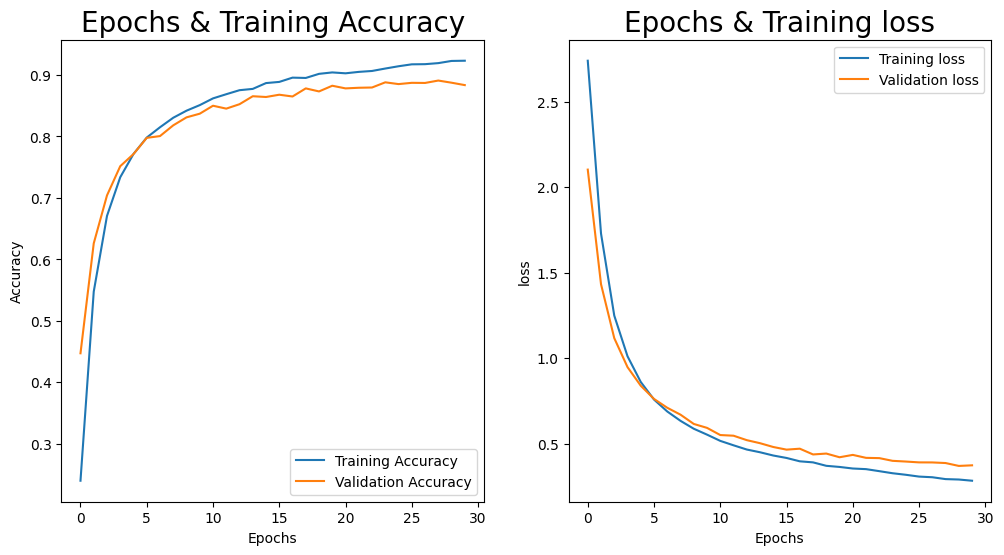

In [29]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))

ax[0].plot(full_history['accuracy'], '-', label = 'Training Accuracy')
ax[0].plot(full_history['val_accuracy'], '-', label = 'Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Epochs & Training Accuracy', fontsize=20)
ax[0].legend(loc='best')

ax[1].plot(full_history['loss'], '-', label = 'Training loss')
ax[1].plot(full_history['val_loss'], '-', label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & Training loss', fontsize=20)
ax[1].legend(loc='best')

plt.show()

In [30]:
test_generator.reset()
pred_resnet = model_resnet.predict(test_generator, verbose=1)

2700/2700 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step


In [31]:
pred_resnet = np.argmax(pred_resnet,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_resnet = [labels[k] for k in pred_resnet]

In [32]:
accuracy_score(test['label'], pred_resnet)

0.9148148148148149

In [33]:
print(classification_report(test['label'], pred_resnet))

              precision    recall  f1-score   support

           A       0.94      0.95      0.95       100
           B       0.97      0.91      0.94       100
       Blank       0.99      0.99      0.99       100
           C       0.98      0.95      0.96       100
           D       0.95      0.88      0.91       100
           E       0.84      0.87      0.86       100
           F       0.90      0.95      0.93       100
           G       0.93      0.97      0.95       100
           H       0.97      0.97      0.97       100
           I       0.88      0.93      0.90       100
           J       0.90      0.94      0.92       100
           K       0.86      0.94      0.90       100
           L       0.99      0.93      0.96       100
           M       0.83      0.75      0.79       100
           N       0.81      0.87      0.84       100
           O       0.93      0.95      0.94       100
           P       0.96      1.00      0.98       100
           Q       0.97    

In [35]:
model_resnet.save('3finalresnet50v2_30_ep.hdf5')